# DGP

We generate $n$ samples from the data generating process:

\begin{align}
z \sim & N(\mu=0, \sigma=I_d)\\
v \sim & N(\mu=0, \sigma=I_d)\\
x = & \gamma z + v\\
y \sim & N(\mu=\langle x + 4 \nu, \theta\rangle, \sigma=1)
\end{align}

where $z$ is a $d$-dimensional instrument, $x$ is a $d$-dimensional treatment, $v$ is an unobserved confounder. Each instrument $z_i$ is an instrument for treatment $x_i$. The coefficient $\theta$ is $s$-sparse. The parameter $\gamma$ controls the strength of the instrument.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, ElasticNetCV, ElasticNet, LassoCV
from mliv.linear import TSLasso, OptimisticHedgeVsOptimisticHedge, StochasticOptimisticHedgeVsOptimisticHedge,\
                        ProxGradientVsHedge, SubGradientVsHedge, L2OptimisticHedgeVsOGD, L2ProxGradient,\
                        L2SubGradient
from mliv.linear.utilities import cross_product

[-1.  1.]


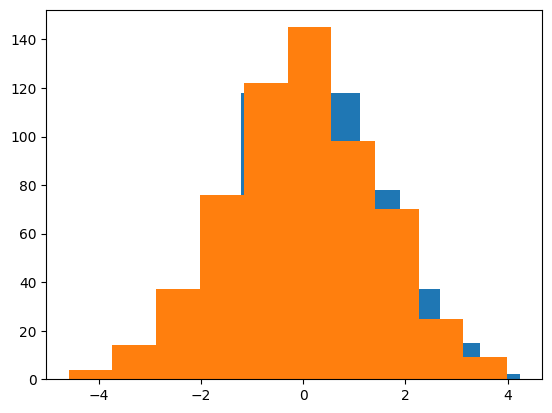

In [3]:
np.random.seed(12)
n = 600
d = 1000
s = 2
gamma = 1
true_coefs = np.zeros(d)
true_coefs[:s] = (2*np.random.binomial(1, .5, size=s)-1) #np.random.uniform(-1, 1, size=s)
z = np.random.normal(0, 1, size=(n, d))
v = np.random.normal(0, 1, size=(n, d))
Gamma = gamma * np.eye(d)
x = z @ Gamma + v
#x[:, :s] = gamma * z[:, :s] - v[:, :s]
y = np.dot(x + v, true_coefs)#+ np.random.normal(0, 1, size=(n,))
print(true_coefs[:s])
plt.hist(x[:, s])
plt.hist(x[:, 1])
plt.show()
z_test = np.random.normal(0, 1, size=(n, d))
v_test = np.random.normal(0, 1, size=(n, 1))
x_test = z_test @ Gamma + v_test

Estimated non-zero coefs:  [-1.39088498  1.41241755]
ell2 error: 0.5684091609372978
RMSE: 0.5529454638297596


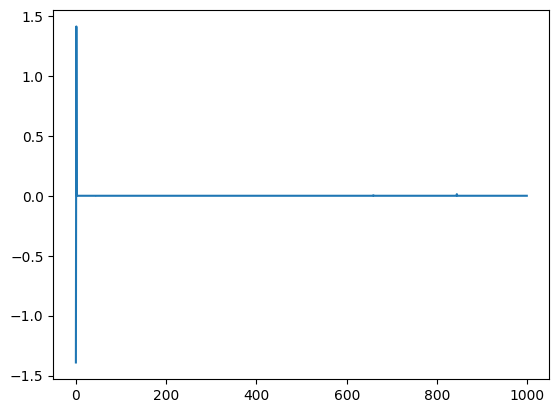

In [4]:
direct = LassoCV(cv=3).fit(x, y)
direct_coefs = direct.coef_
print("Estimated non-zero coefs: ", direct_coefs[:s])
print("ell2 error:", np.linalg.norm(direct_coefs-true_coefs, ord=2))
print("RMSE:", np.sqrt(np.mean(np.dot(x_test, direct_coefs - true_coefs)**2)))
plt.plot(direct_coefs)
plt.show()

In [5]:
gamma = np.min(np.linalg.eigvalsh(Gamma.T @ Gamma))
gamma/(8*s)

0.0625

# Two Stage Lasso

Estimated non-zero coefs:  [-1.38569662  1.42019711]
ell2 error: 0.5704108682791951
RMSE: 0.5554409152618587


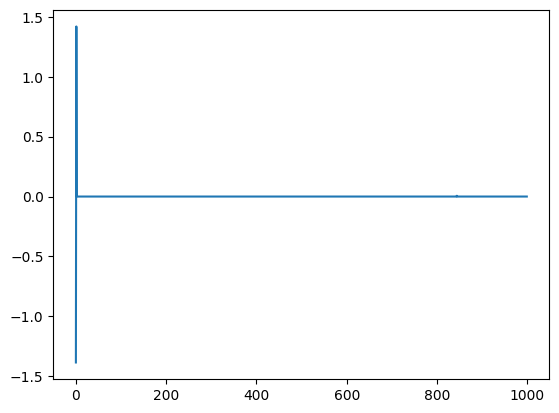

In [6]:
tslasso = TSLasso(first_stage=Lasso(alpha=.01)).fit(z, x, y)
tslasso_coefs = tslasso.coef_
print("Estimated non-zero coefs: ", tslasso_coefs[:s])
print("ell2 error:", np.linalg.norm(tslasso_coefs-true_coefs, ord=2))
print("RMSE:", np.sqrt(np.mean(np.dot(x_test, tslasso_coefs - true_coefs)**2)))
plt.plot(tslasso_coefs)
plt.show()

Maximum violation:  0.11905333481420144
Estimated non-zero coefs:  [-1.08121478  1.1023699 ]
ell2 error: 0.14624582737941086
RMSE: 0.18233402656878298
Min/Max:  0.2655830494256917 0.26943696403016915
Dualit Gap:  0.0038539146044774264
Iters:  10000


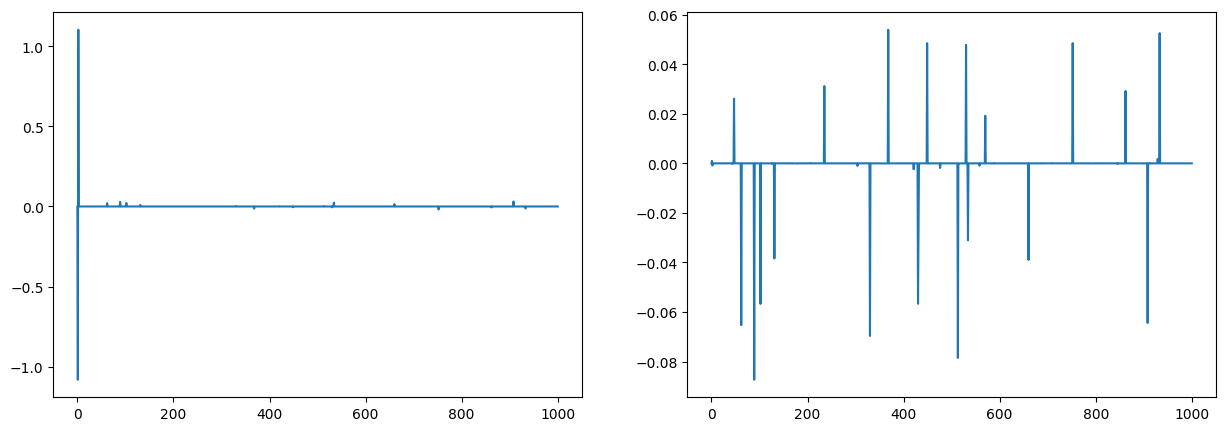

In [7]:
est = OptimisticHedgeVsOptimisticHedge(B=3, lambda_theta=gamma/(8*s),
                                       eta_theta=.5,
                                       eta_w=.5,
                                       n_iter=10000, tol=.0001, sparsity=None).fit(z, x, y)
coefs = est.coef
print("Maximum violation: ", est.max_violation_)
print("Estimated non-zero coefs: ", coefs[:s])
print("ell2 error:", np.linalg.norm(coefs-true_coefs, ord=2))
print("RMSE:", np.sqrt(np.mean(np.dot(x_test, coefs - true_coefs)**2)))
print("Min/Max: ", est.min_response_loss_, est.max_response_loss_)
print("Dualit Gap: ", est.duality_gap_)
print("Iters: ", est.n_iters_)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(est.coef_)
plt.subplot(1,2,2)
plt.plot(est.w_)
plt.show()

Maximum violation:  0.21443297803439207
Estimated non-zero coefs:  [-1.19954505  1.23376592]
ell2 error: 0.31171872466946116
RMSE: 0.3112700245489688
Min/Max:  0.09252986653958384 0.3832305568597978
Dualit Gap:  0.29070069032021395
Iters:  1000


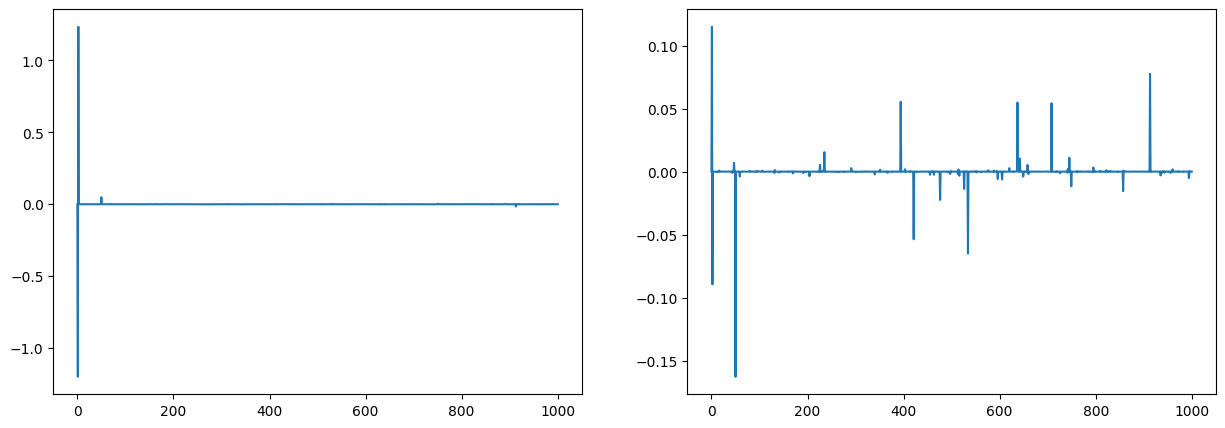

In [8]:
stochest = StochasticOptimisticHedgeVsOptimisticHedge(B=3, lambda_theta=gamma/(8*s),
                                       eta_theta=.1, eta_w=.1,
                                       n_iter=1000, tol=1/n).fit(z, x, y)
stochcoefs = stochest.coef
print("Maximum violation: ", stochest.max_violation_)
print("Estimated non-zero coefs: ", stochcoefs[:s])
print("ell2 error:", np.linalg.norm(stochcoefs-true_coefs, ord=2))
print("RMSE:", np.sqrt(np.mean(np.dot(x_test, stochcoefs - true_coefs)**2)))
print("Min/Max: ", stochest.min_response_loss_, stochest.max_response_loss_)
print("Dualit Gap: ", stochest.duality_gap_)
print("Iters: ", stochest.n_iters_)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(stochest.coef_)
plt.subplot(1,2,2)
plt.plot(stochest.w_)
plt.show()

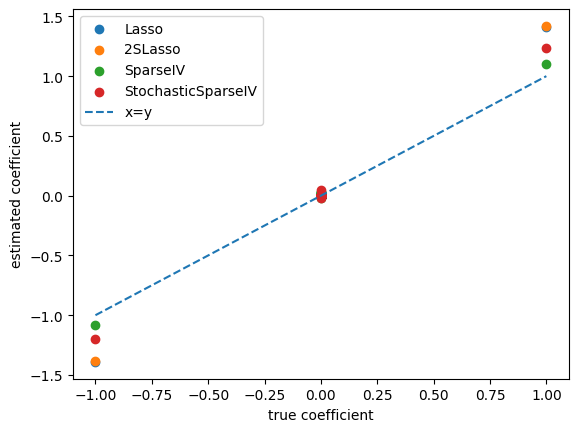

In [9]:
plt.scatter(true_coefs, direct_coefs, label='Lasso')
plt.scatter(true_coefs, tslasso_coefs, label='2SLasso')
plt.scatter(true_coefs, coefs, label='SparseIV')
plt.scatter(true_coefs, stochcoefs, label='StochasticSparseIV')
plt.plot(np.linspace(np.min(true_coefs), np.max(true_coefs), 10),
         np.linspace(np.min(true_coefs), np.max(true_coefs), 10), '--', label='x=y')
plt.xlabel('true coefficient')
plt.ylabel('estimated coefficient')
plt.legend()
plt.savefig('true_v_est_sparse_linear.png')
plt.show()

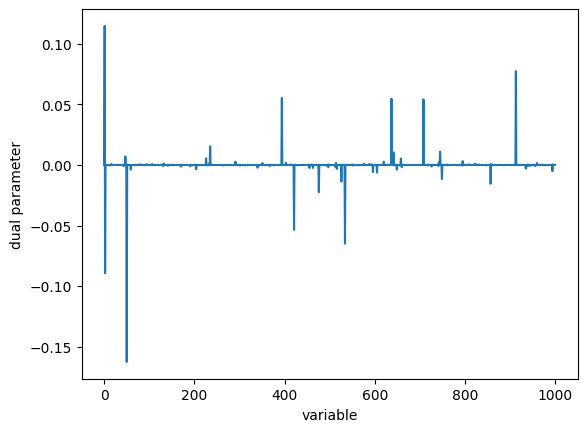

In [10]:
plt.plot(stochest.w_)
plt.xlabel('variable')
plt.ylabel('dual parameter')
plt.savefig('duals.png')
plt.show()

In [11]:
print("ell2 error:", np.linalg.norm(coefs-true_coefs, ord=np.inf))

ell2 error: 0.1023698998554643


### Optimistic Proximal Gradient vs Optimistic MWU

Maximum violation:  0.11994840225278075
Estimated non-zero coefs:  [-1.0805281   1.09824869]
ell2 error: 0.14197424074491602
RMSE: 0.17333966906367407
Min/Max:  0.2671540492394351 0.26881797597640433
Dualit Gap:  0.0016639267369692456
Iters:  3350


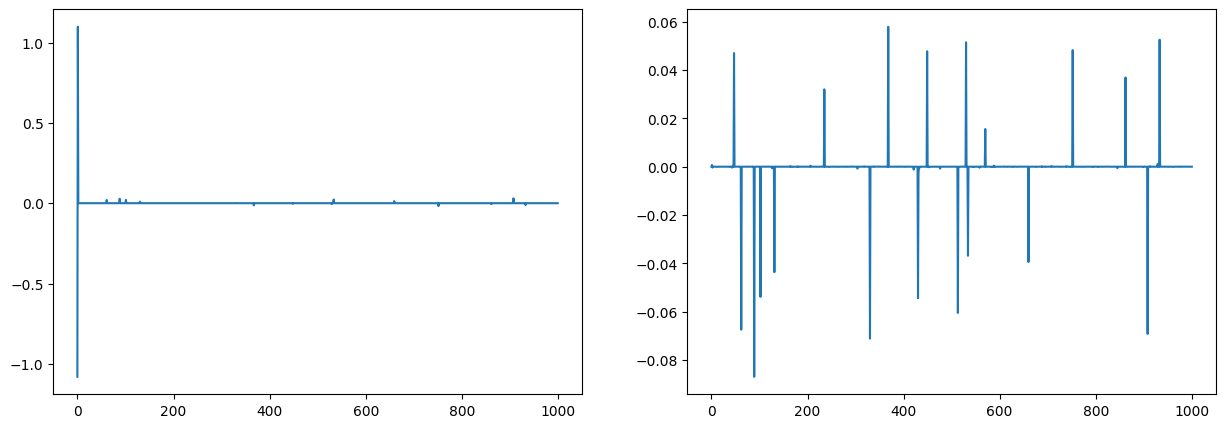

In [12]:
est = ProxGradientVsHedge(B=3, lambda_theta=gamma/(8*s),
                          eta_theta=1, eta_w=1,
                          n_iter=10000, tol=1/n).fit(z, x, y)
coefs = est.coef
print("Maximum violation: ", est.max_violation_)
print("Estimated non-zero coefs: ", coefs[:s])
print("ell2 error:", np.linalg.norm(coefs-true_coefs, ord=2))
print("RMSE:", np.sqrt(np.mean(np.dot(x_test, coefs - true_coefs)**2)))
print("Min/Max: ", est.min_response_loss_, est.max_response_loss_)
print("Dualit Gap: ", est.duality_gap_)
print("Iters: ", est.n_iters_)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(coefs)
plt.subplot(1,2,2)
plt.plot(est.w_)
plt.show()

### Simultaneous Descent: Subgradient Descent vs MWU


Maximum violation:  0.12309243316212899
Estimated non-zero coefs:  [-1.04442809  1.09312141]
ell2 error: 0.11841559729509268
RMSE: 0.18188382416780163
Min/Max:  0.24390317133720624 0.2814056521381822
Dualit Gap:  0.03750248080097596
Iters:  10000


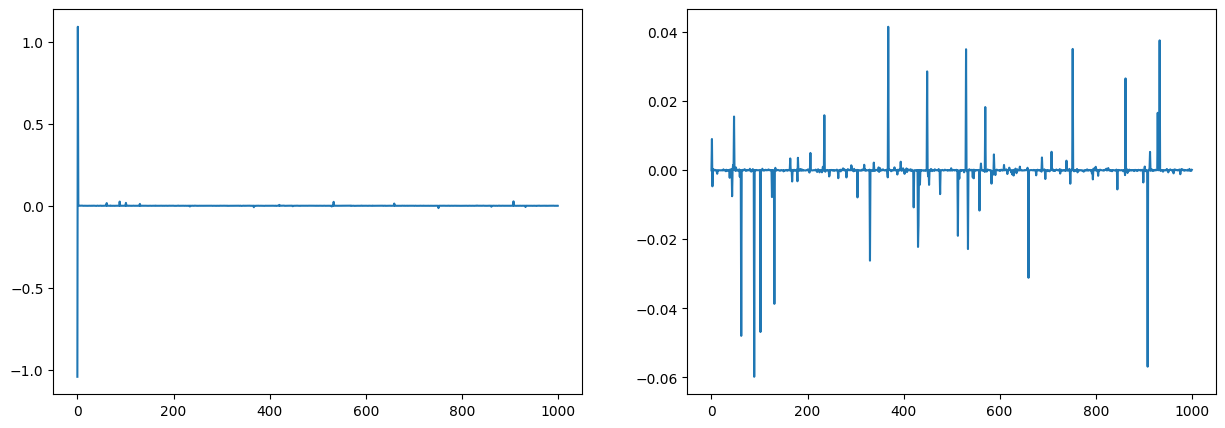

In [13]:
est = SubGradientVsHedge(B=3, lambda_theta=gamma/(8*s),
                         eta_theta='auto', eta_w='auto',
                         n_iter=10000, tol=1/n**(2/3)).fit(z, x, y)
coefs = est.coef
print("Maximum violation: ", est.max_violation_)
print("Estimated non-zero coefs: ", coefs[:s])
print("ell2 error:", np.linalg.norm(coefs-true_coefs, ord=2))
print("RMSE:", np.sqrt(np.mean(np.dot(x_test, coefs - true_coefs)**2)))
print("Min/Max: ", est.min_response_loss_, est.max_response_loss_)
print("Dualit Gap: ", est.duality_gap_)
print("Iters: ", est.n_iters_)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(coefs)
plt.subplot(1,2,2)
plt.plot(est.w_)
plt.show()

# L2 Adversary

In [14]:
#np.random.seed(1456)
n = 5000
d_x = 10
d_z = 100
s = 2
gamma = 1
true_coefs = np.zeros(d_x)
true_coefs[1] = 2*(2*np.random.binomial(1, .5,)-1)
sigma_z = 1
z = np.random.normal(0, sigma_z, size=(n, d_z))
v = np.random.normal(0, 1, size=(n, 1))
Gamma = np.random.normal(0, 1, size=(d_z, d_x))
Gamma[d_z//2:, 0] = 0
Gamma[:d_z//2, 1] = 0
Gamma /= np.linalg.norm(Gamma, ord=2, axis=0, keepdims=True)
x = z @ Gamma + v
y = np.dot(x, true_coefs) + v[:, 0] #+ np.random.normal(0, 1, size=(n,))
print(true_coefs[:s])

z_test = np.random.normal(0, 1, size=(n, d_z))
v_test = np.random.normal(0, 1, size=(n, 1))
x_test = z_test @ Gamma + v_test

[0. 2.]


In [15]:
gamma = np.min(np.linalg.eigvalsh(Gamma.T @ Gamma)) * (sigma_z**2)
gamma

0.47657498635394036

Estimated non-zero coefs:  [0.         1.99186671]
ell2 error: 0.008133285219100284
RMSE: 0.01148018905680122


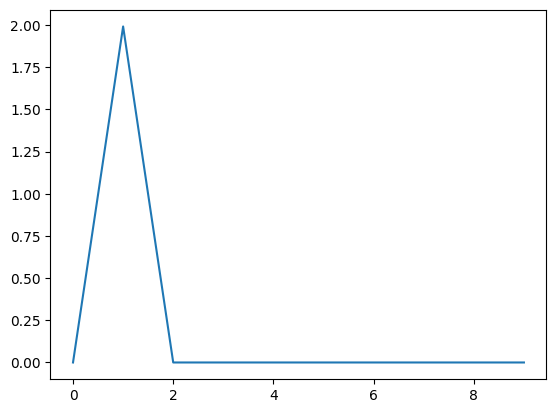

In [16]:
est = TSLasso(first_stage=ElasticNet(l1_ratio=.05, alpha=0.001)).fit(z, x, y)
coefs = est.coef_
print("Estimated non-zero coefs: ", coefs[:s])
print("ell2 error:", np.linalg.norm(coefs-true_coefs, ord=2))
print("RMSE:", np.sqrt(np.mean(np.dot(x_test, coefs - true_coefs)**2)))
plt.plot(coefs)
plt.show()

Maximum violation:  0.04826908954654069
Estimated non-zero coefs:  [0.01451308 2.02686566]
ell2 error: 0.05685313234708413
RMSE: 0.148321371548244
Min/Max:  0.19435298626753228 0.19720962687729893
Dualit Gap:  0.0028566406097666475
Iterations:  10000


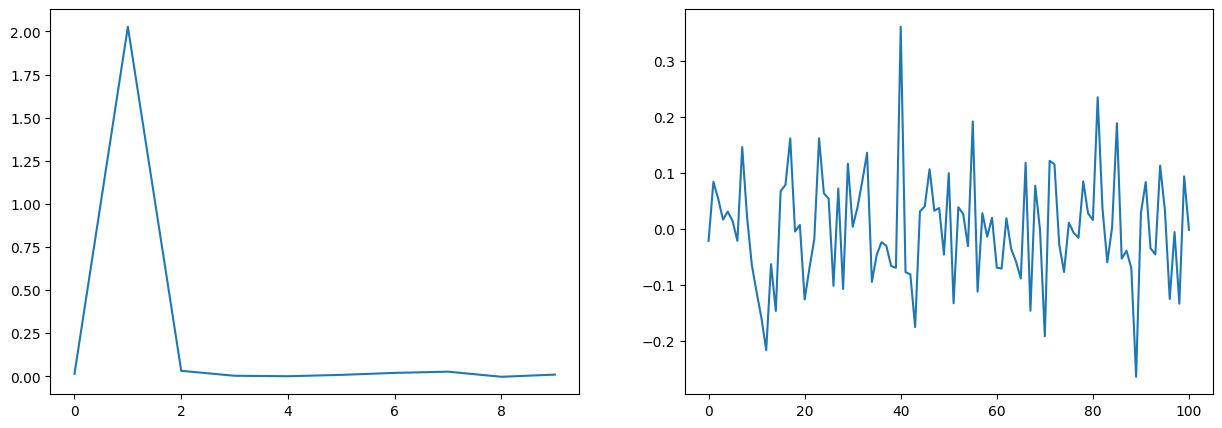

In [17]:
est = L2OptimisticHedgeVsOGD(B=3, tol=1/n, lambda_theta=gamma/(8*s),
                     n_iter=10000, eta_theta=.1, eta_w=.1, sparsity=None).fit(z, x, y)
coefs = est.coef
print("Maximum violation: ", est.max_violation_)
print("Estimated non-zero coefs: ", coefs[:s])
print("ell2 error:", np.linalg.norm(coefs-true_coefs, ord=2))
print("RMSE:", np.sqrt(np.mean(np.dot(x_test, coefs - true_coefs)**2)))
print("Min/Max: ", est.min_response_loss_, est.max_response_loss_)
print("Dualit Gap: ", est.duality_gap_)
print("Iterations: ", est.n_iters_)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(coefs)
plt.subplot(1,2,2)
plt.plot(est.w_)
plt.show()

Maximum violation:  0.05202558484218952
Estimated non-zero coefs:  [0.01749664 1.98762229]
ell2 error: 0.06281434013042578
RMSE: 0.1500429208171998
Min/Max:  0.13598141877939685 0.14067881310685548
Dualit Gap:  0.004697394327458637


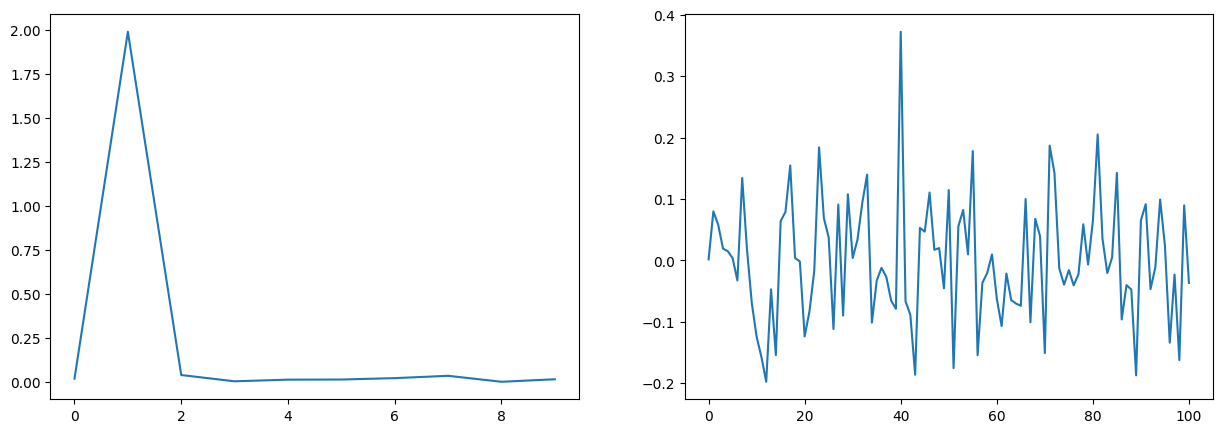

In [18]:
est = L2ProxGradient(B=2, tol=.0001, lambda_theta=.0001,
                     n_iter=10000).fit(z, x, y)
coefs = est.coef
print("Maximum violation: ", est.max_violation_)
print("Estimated non-zero coefs: ", coefs[:s])
print("ell2 error:", np.linalg.norm(coefs-true_coefs, ord=2))
print("RMSE:", np.sqrt(np.mean(np.dot(x_test, coefs - true_coefs)**2)))
print("Min/Max: ", est.min_response_loss_, est.max_response_loss_)
print("Dualit Gap: ", est.duality_gap_)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(coefs)
plt.subplot(1,2,2)
plt.plot(est.w_)
plt.show()

Maximum violation:  0.05213533730799398
Estimated non-zero coefs:  [0.01346351 1.9595053 ]
ell2 error: 0.06668521189308514
RMSE: 0.10999140386669282
Min/Max:  0.19740127833029797 0.2158667835524761
Dualit Gap:  0.01846550522217813


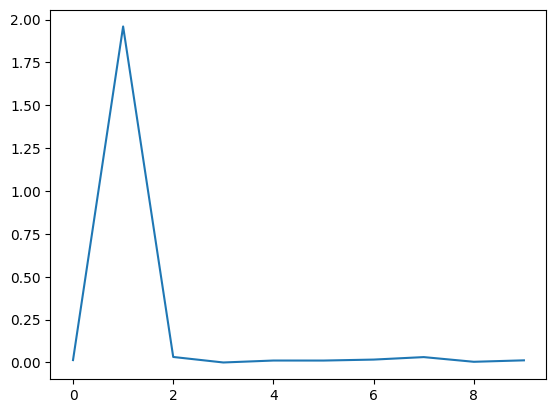

In [19]:
est = L2SubGradient(B=2, lambda_theta=gamma/(8*s), n_iter=1000).fit(z, x, y)
coefs = est.coef
print("Maximum violation: ", est.max_violation_)
print("Estimated non-zero coefs: ", coefs[:s])
print("ell2 error:", np.linalg.norm(coefs-true_coefs, ord=2))
print("RMSE:", np.sqrt(np.mean(np.dot(x_test, coefs - true_coefs)**2)))
print("Min/Max: ", est.min_response_loss_, est.max_response_loss_)
print("Dualit Gap: ", est.duality_gap_)
plt.plot(coefs)
plt.show()